In [2]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms


In [3]:
from torchtext import data

In [4]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader,Dataset

## Load Fasttext model

In [7]:
import fasttext.util

In [8]:
ft = fasttext.load_model('FastText Model/cc.en.300.bin')

In [9]:
ft.get_dimension()

300

## Text preprocessing

In [10]:
train_df=pd.read_csv('data/sst_train.txt', names=['label','text'],sep='\t')
test_df=pd.read_csv('data/sst_test.txt',names=['label','text'],sep='\t')
val_df=pd.read_csv('data/sst_dev.txt',names=['label','text'],sep='\t')

In [11]:
tokenizer=get_tokenizer('spacy',language="en_core_web_sm")

In [12]:
def get_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(''.join(text))

In [13]:
def clean_texts(texts):
    texts=re.sub(r"[^a-zA-Z0-9]", ' ', texts)
    texts=re.sub(r" +",' ', texts)
    texts=texts.lower()
    return texts

In [14]:
train_df['text']=train_df['text'].apply(lambda x:clean_texts(x))

In [15]:
test_df['text']=test_df['text'].apply(lambda x:clean_texts(x))
val_df['text']=val_df['text'].apply(lambda x:clean_texts(x))

### Get features from sentences using ft.get_sentence_vector()

In [19]:
def get_features(text):
    vector=ft.get_sentence_vector(text)
    vector=vector/np.linalg.norm(vector)
    torch_vector=torch.tensor(vector,dtype=torch.float32)
    return torch_vector

In [20]:
train_df['features']=train_df['text'].apply(lambda x:get_features(x))

In [21]:
test_df['features']=test_df['text'].apply(lambda x:get_features(x))
val_df['features']=val_df['text'].apply(lambda x:get_features(x))

### Define dataset class

In [84]:
class review_data(Dataset):
    def __init__(self,dataframe):
        self.text=dataframe['text']
        self.label=dataframe['label']
        self.features=dataframe['features']

    def __getitem__(self,index):
        return (self.label[index],self.text[index],self.features[index])
    
    def __len__(self):
        return len(self.label)

In [85]:
train_data=review_data(train_df)

In [86]:
dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

In [167]:
INPUT_SHAPE=300

## Define classification model

In [211]:
from torch import nn
import torch.nn.functional as F
class TextClassificationModel(nn.Module):

    def __init__(self):
        super(TextClassificationModel, self).__init__()
        self.fc1=nn.Linear(in_features=INPUT_SHAPE,out_features=64)

        self.out=nn.Linear(in_features=64,out_features=5)

    def forward(self,t):
        # Input layer
        t=self.fc1(t)
        t=F.relu(t)

        # Output layer
        t=self.out(t)

        return t

## Create model object and train

In [212]:
model = TextClassificationModel()

In [213]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

In [214]:
test_data=review_data(test_df)
val_data=review_data(val_df)

In [215]:
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=False)
val_dataloader = DataLoader(val_data,batch_size=32,shuffle=False)

### Define training function

In [216]:
def train(dataloader):
    model.train()
    total_acc,total_count=0,0
    for batch in dataloader:
        label,text,features=batch
        
        predicted_label = model(features)
        loss = F.cross_entropy(predicted_label, label)
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)
        optimizer.step()
        total_acc+=(predicted_label.argmax(1)==label).sum().item()
        total_count+=label.size(0)
    print(f'! epoch{epoch} | Training accuracy {total_acc/total_count}')

In [217]:
def evaluate(dataloader):
    model.eval()
    total_acc,total_count,total_loss=0,0,0
    with torch.no_grad():
            for batch in dataloader:
                label,text,features=batch
                predicted_label = model(features)
                loss = criterion(predicted_label, label)
                total_loss+=loss
                total_acc += (predicted_label.argmax(1) == label).sum().item()
                total_count += label.size(0)
            return total_acc/total_count, total_loss

### Define optimizers

In [218]:
# Hyperparameters
EPOCHS = 10 # epoch
LR = 0.01  # learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_accu = None

In [219]:
train_dataloader=DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=False)
val_dataloader = DataLoader(val_data,batch_size=32,shuffle=True)

In [220]:
import time

### Train model

In [221]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val,val_loss = evaluate(val_dataloader)
    total_accu = accu_val
    print(f'| end of epoch {epoch} | time: {time.time()-epoch_start_time}s | val accuracy: {accu_val} | val loss {val_loss}')
    print('-' * 120)

! epoch1 | Training accuracy 0.3993445692883895
| end of epoch 1 | time: 0.33611583709716797s | val accuracy: 0.4223433242506812 | val loss 44.812198638916016
------------------------------------------------------------------------------------------------------------------------
! epoch2 | Training accuracy 0.4477996254681648
| end of epoch 2 | time: 0.33011674880981445s | val accuracy: 0.43415077202543145 | val loss 45.23979568481445
------------------------------------------------------------------------------------------------------------------------
! epoch3 | Training accuracy 0.46125936329588013
| end of epoch 3 | time: 0.3640422821044922s | val accuracy: 0.43505903723887374 | val loss 44.46986770629883
------------------------------------------------------------------------------------------------------------------------
! epoch4 | Training accuracy 0.47624063670411987
| end of epoch 4 | time: 0.42487621307373047s | val accuracy: 0.43415077202543145 | val loss 44.33792495727539


In [222]:
evaluate(test_dataloader)

(0.4411764705882353, tensor(94.2350))

In [223]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, f1_score
def test_metrics(dataloader):
    model.eval()
    total_acc,total_count=0,0
    preds=[]
    with torch.no_grad():
            for batch in dataloader:
                label,text,features=batch
                predicted_label = model(features)
                loss = criterion(predicted_label, label)
                total_acc += (predicted_label.argmax(1) == label).sum().item()
                preds.append(predicted_label.argmax(1))
                total_count += label.size(0)
            predicted_labels=torch.cat(preds,dim=0)
            f1_s=f1_score(torch.tensor(test_df['label']),predicted_labels,average='macro')
            print("F1-score =",f1_s)
            cm=confusion_matrix(torch.tensor(test_df['label']),predicted_labels)
            plt.figure(figsize = (10,7))
            sns.heatmap(cm,annot=True)
            return total_acc/total_count, predicted_labels

F1-score = 0.4105923125511947


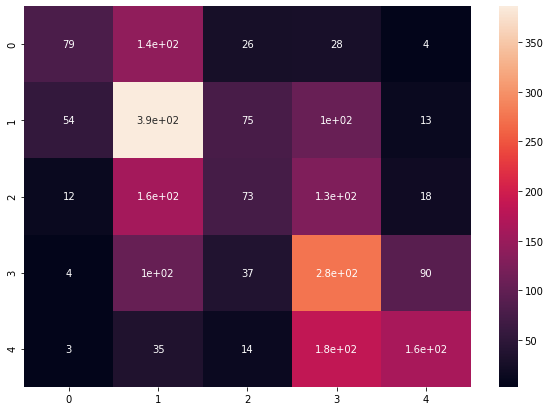

In [224]:
_,test_preds=test_metrics(test_dataloader)

In [225]:
torch.tensor(test_df['label'])

tensor([2, 3, 4,  ..., 4, 3, 0])

In [226]:
print(accuracy_score(torch.tensor(test_df['label']),test_preds))

0.4411764705882353
